In [12]:
import argparse
import os
import re
import numpy as np
import pandas as pd
from datetime import datetime
import skimage
import geopandas as gpd
import pyproj
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [13]:
import skimage.draw

### Clip the study region

In [2]:
img_dir = 'N:/dataorg-datasets/MLsatellite/sentinel2_images/images_danya/'

In [5]:
def dropna_in_shapefile(from_shp_path, to_shp_path=None):
    shapefile = gpd.read_file(from_shp_path)
    shapefile = shapefile.dropna().reset_index(drop=True)
    if to_shp_path is None:
        shapefile.to_file(from_shp_path)
    else:
        shapefile.to_file(to_shp_path)

In [6]:
dropna_in_shapefile('../data/labels/labels.shp', '../data/labels/labels_dropna.shp')

In [8]:
def clip_all_rasters(images_dir, shape_filepath='../data/study-area/study_area.shp'):
    # shape file information
    with fiona.open(shape_filepath, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile if feature["geometry"] is not None]
    shape_crs = gpd.read_file(shape_filepath).crs

    # geotiff directory
    geotiff_dir = images_dir + 'geotiff/'
    # clip directory
    clip_dir = images_dir + 'clip/'
    if not os.path.exists(clip_dir):
        os.mkdir(clip_dir)

    # clip all the raster
    for filename in [f for f in os.listdir(geotiff_dir) if f.endswith('.tiff')]:
        geotiff_filepath = geotiff_dir + filename
        clip_filepath = clip_dir + filename
        clip_single_raster(shape_crs, shapes, geotiff_filepath, clip_filepath)


def clip_single_raster(shape_crs, shapes, geotiff_filepath, clip_filepath):
    # get the coordinate system of raster
    raster = rasterio.open(geotiff_filepath)

    # check if two coordinate systems are the same
    if shape_crs != raster.crs:
        reproject_single_raster(shape_crs, geotiff_filepath, clip_filepath)
        # read imagery file
        with rasterio.open(clip_filepath) as src:
            out_image, out_transform = mask(src, shapes, crop=True)
            out_meta = src.meta
    else:
        # read imagery file
        with rasterio.open(geotiff_filepath) as src:
            out_image, out_transform = mask(src, shapes, crop=True)
            out_meta = src.meta

    # Save clipped imagery
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(clip_filepath, "w", **out_meta) as dest:
        dest.write(out_image)


def reproject_single_raster(dst_crs, input_file, transformed_file):
    """
    :param dst_crs: output projection system
    :param input_file
    :param transformed_file
    :return:
    """
    with rasterio.open(input_file) as imagery:
        transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height,
                                                               *imagery.bounds)
        kwargs = imagery.meta.copy()
        kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
        with rasterio.open(transformed_file, 'w', **kwargs) as dst:
            for i in range(1, imagery.count + 1):
                reproject(
                    source=rasterio.band(imagery, i),
                    destination=rasterio.band(dst, i),
                    src_transform=imagery.transform,
                    src_crs=imagery.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [ ]:
clip_all_rasters(img_dir)

In [14]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min + 1e-6)

In [15]:
def show_true_color(raster, is_norm=True):
    # Convert to numpy arrays
    blue = raster.read(1)
    green = raster.read(2)
    red = raster.read(3)
    
    # Normalize bands into 0.0 - 1.0 scale
    if is_norm:
        blue = normalize(blue)
        green = normalize(green)
        red = normalize(red)

    # Stack bands
    img_rgb = np.dstack((red, green, blue))

    # View the color composite
    # fig = plt.subplots(figsize=(6,6))
    plt.imshow(img_rgb)

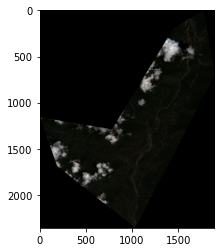

In [17]:
# show an example 
example = rasterio.open(img_dir+'clip/L2A_T43SFR_A026271_20200703T053446.tiff')
show_true_color(example, is_norm=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


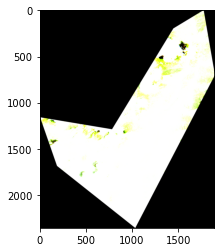

In [18]:
show_true_color(example, is_norm=False)

In [19]:
print(f'The example has {example.count} bands.')

The example has 4 bands.


### Read images

For classic classifiers, no need to crop into patches since model.fit(x) requires all the training data points.

In [20]:
def load_geotiff(path, window=None):
    """ Load the geotiff as a list of numpy array.
        INPUT : path (str) -> the path to the geotiff
                window (raterio.windows.Window) -> the window to use when loading the image
        OUTPUT : band (list of numpy array) -> the different bands as float scalled to 0:1
                 meta (dictionnary) -> the metadata associated with the geotiff
    """
    with rasterio.open(path) as f:
        band = [skimage.img_as_float(f.read(i+1, window=window)) for i in range(f.count)]
        meta = f.meta
        if window != None:
            meta['height'] = window.height
            meta['width'] = window.width
            meta['transform'] = f.window_transform(window)
    return band, meta

In [21]:
def stack_all_timestamps(from_dir):
    # stack images of different timestamp
    stacked_raster = dict(band=[], meta=[], timestamp=[])
    for filename in os.listdir(from_dir):
        raster_filepath = from_dir + filename
        band, meta = load_geotiff(raster_filepath)
        timestamp = re.split('[_.]', filename)[-2]
        stacked_raster['band'].append(np.stack(band, axis=2))
        stacked_raster['meta'] = meta
        stacked_raster['timestamp'].append(datetime.strptime(timestamp, '%Y%m%dT%H%M%S%f'))
    return stacked_raster 

In [22]:
stacked_raster = stack_all_timestamps(img_dir+'clip/')

In [23]:
stacked_band = np.array(stacked_raster['band'])

In [24]:
stacked_band.shape

(5, 2357, 1892, 4)

### Pre-processing images

No spatial relation is considered.

In [25]:
def get_statictics(opt, data, axis):
    if opt == 'avg':
        return np.mean(data, axis=axis)
    elif opt == 'std':
        return np.std(data, axis=axis)
    elif opt == 'max':
        return np.max(data, axis=axis)
    else:
        return 'No corresponding calculation.'

In [26]:
def preprocessing(stacked_band_array):
    df = pd.DataFrame()
    for i, band in enumerate(['blue', 'green', 'red', 'nir']):
        for opt in ['avg', 'std', 'max']:
            col_name = band + '_' + opt 
            reshaped_band = stacked_band[..., i].reshape(stacked_band[..., i].shape[0], -1)
            df[col_name] = get_statictics(opt, reshaped_band, 0)
    return df

In [27]:
df = preprocessing(stacked_band)

In [28]:
df

,blue_avg,blue_std,blue_max,green_avg,green_std,green_max,red_avg,red_std,red_max,nir_avg,nir_std,nir_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4459439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4459440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4459441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4459442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Prepare labels

Assuming only one-level model, use only given labels.

In [302]:
apples_shp = gpd.read_file('../data/survey-polygons/survey20210716_polygons20210819.shp')
noncrop_shp = gpd.read_file('../data/non-crop/non-crop.shp')
labels_shp = gpd.read_file('../data/labels/labels_dropna.shp')

<AxesSubplot:>

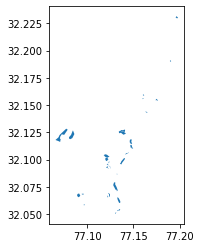

In [303]:
noncrop_shp.plot()

<AxesSubplot:>

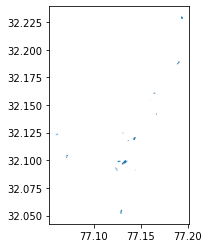

In [304]:
apples_shp.plot()

<AxesSubplot:>

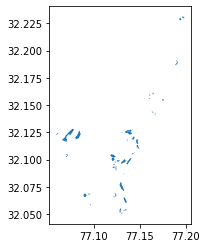

In [7]:
labels_shp.plot()

In [37]:
labels_shp = gpd.read_file('../data/labels/labels_dropna.shp')
noncrop_shp = gpd.read_file('../data/non-crop/non-crop.shp')
apples_shp = gpd.read_file('../data/survey-polygons/survey20210716_polygons20210819.shp')

<AxesSubplot:>

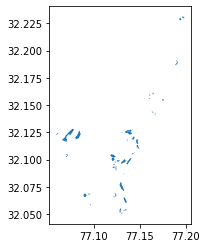

In [38]:
labels_shp.plot()

<AxesSubplot:>

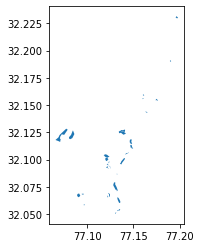

In [39]:
noncrop_shp.plot()

<AxesSubplot:>

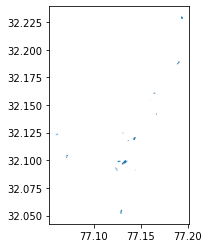

In [40]:
apples_shp.plot()

In [49]:
def load_target_shp(path, transform=None, proj_out=None):
    """ Load the shapefile as a list of numpy array of coordinates
        INPUT : path (str) -> the path to the shapefile
                transform (rasterio.Affine) -> the affine transformation to get the polygon in row;col format from UTM.
        OUTPUT : poly (list of np.array) -> list of polygons (as numpy.array of coordinates)
                 poly_rc (list of np.array) -> list of polygon in row-col format if a transform is given
    """
    with fiona.open(path) as shapefile:
        proj_in = pyproj.Proj(shapefile.crs)
        class_type = [feature['properties']['id'] for feature in shapefile]
        features = [feature["geometry"] for feature in shapefile]
    # reproject polygons if necessary
    if proj_out is None or proj_in == proj_out:
        poly = [np.array([(coord[0], coord[1]) for coord in features[i]['coordinates'][0]]) for i in range(len(features))]
        print('No reprojection!')
    else:
        poly = [np.array([pyproj.transform(proj_in, proj_out, coord[0], coord[1]) for coord in features[i]['coordinates'][0]]) for i in range(len(features))]
        print(f'Reproject from {proj_in} to {proj_out}')
              
    poly_rc = None
    # transform in row-col if a transform is given
    if not transform is None:
        poly_rc = [np.array([rasterio.transform.rowcol(transform, coord[0], coord[1])[::-1] for coord in p]) for p in poly]

    return poly, poly_rc, class_type

def compute_mask(polygon_list, img_w, img_h, val_list):
    """ Get mask of class of a polygon list
        INPUT : polygon_list (list od polygon in coordinates (x, y)) -> the polygons in row;col format
                img_w (int) -> the image width
                img_h (int) -> the image height
                val_list(list of int) -> the class associated with each polygon
        OUTPUT : img (np.array 2D) -> the mask in which the pixel value reflect it's class (zero being the absence of class)
    """
    img = np.zeros((img_h, img_w), dtype=np.uint8) #skimage : row,col --> h,w
    for polygon, val in zip(polygon_list, val_list):
        rr, cc = skimage.draw.polygon(polygon[:,1], polygon[:,0], img.shape)
        img[rr, cc] = val

    return img

In [50]:
meta_train = example.meta

# %% load label shapefile
polygons_train, polygons_rc_train, class_list = \
    load_target_shp('../data/labels/labels_dropna.shp', 
                    transform=meta_train['transform'], 
                    proj_out=pyproj.Proj(meta_train['crs']))
mask_train = compute_mask(polygons_rc_train, 
                          meta_train['width'], 
                          meta_train['height'], 
                          class_list)

No reprojection!


C:\Users\lida\Anaconda3\envs\ml4sat\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
# %% load label shapefile
_, region_rc_mask, region_list = \
    load_target_shp('../data/study-area/study_area.shp', 
                    transform=meta_train['transform'], 
                    proj_out=pyproj.Proj(meta_train['crs']))
region_mask = compute_mask(region_rc_mask, 
                          meta_train['width'], 
                          meta_train['height'], 
                          region_list)

C:\Users\lida\Anaconda3\envs\ml4sat\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


No reprojection!


In [666]:
count_classes(region_mask)

Number of pixel taking 0 is 2692384
Number of pixel taking 1 is 1767060


### Pair x and y, split train and val

In [56]:
print(f'df = {df.shape[0]}, mask_train = {mask_train.reshape(-1).shape[0]}')

df = 4459444, mask_train = 4459444


In [57]:
df['label'] = mask_train.reshape(-1)

In [58]:
df

,blue_avg,blue_std,blue_max,green_avg,green_std,green_max,red_avg,red_std,red_max,nir_avg,nir_std,nir_max,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4459440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4459441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4459442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [59]:
from sklearn.model_selection import train_test_split

In [66]:
df_train_val = df[df['label'] != 0].reset_index(drop=True)

In [67]:
df_train_val

,blue_avg,blue_std,blue_max,green_avg,green_std,green_max,red_avg,red_std,red_max,nir_avg,nir_std,nir_max,label
0,0.008127,0.006653,0.014405,0.006802,0.005631,0.013016,0.005472,0.004507,0.010208,0.016693,0.013706,0.030457,2
1,0.011026,0.009004,0.018631,0.009262,0.007578,0.016251,0.007944,0.006502,0.013993,0.014356,0.011745,0.025162,2
2,0.011063,0.009036,0.018784,0.009256,0.007569,0.016144,0.007990,0.006543,0.014069,0.014350,0.011739,0.025147,2
3,0.013721,0.011274,0.024125,0.014466,0.011886,0.025452,0.015271,0.012631,0.028031,0.021128,0.017286,0.036454,2
4,0.017697,0.014464,0.030137,0.020224,0.016536,0.035279,0.021128,0.017311,0.037491,0.025715,0.021049,0.044999,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22134,0.005289,0.004516,0.011200,0.007034,0.005839,0.013535,0.006937,0.005710,0.012879,0.023896,0.019532,0.041444,2
22135,0.003201,0.002880,0.007538,0.006207,0.005173,0.012222,0.004678,0.004062,0.010315,0.031318,0.025573,0.052781,2
22136,0.012793,0.010449,0.021759,0.015302,0.012496,0.025910,0.015769,0.012878,0.026612,0.023258,0.018992,0.039139,2
22137,0.007813,0.006534,0.015259,0.009995,0.008242,0.018143,0.009717,0.007995,0.017578,0.026749,0.021856,0.045335,2


In [71]:
x = df_train_val.iloc[:,:-1].values
y = df_train_val.label.values

In [74]:
x, y

(array([[0.00812696, 0.00665308, 0.01440452, ..., 0.01669337, 0.01370629,
         0.03045701],
        [0.01102617, 0.00900433, 0.01863127, ..., 0.01435569, 0.01174535,
         0.02516213],
        [0.01106279, 0.00903639, 0.01878386, ..., 0.01434958, 0.01173934,
         0.02514687],
        ...,
        [0.01279316, 0.01044877, 0.02175937, ..., 0.0232578 , 0.01899159,
         0.03913939],
        [0.00781262, 0.00653378, 0.01525902, ..., 0.02674907, 0.02185608,
         0.04533455],
        [0.01212482, 0.0099105 , 0.02095064, ..., 0.02178378, 0.01778764,
         0.03668269]]),
 array([2, 2, 2, ..., 2, 2, 2], dtype=uint8))

In [106]:
def count_classes(y):
    for i in np.unique(y):
        print(f'Number of pixel taking {i} is {y[y==i].shape[0]}')

In [107]:
count_classes(y)

Number of pixel taking 1 is 4391
Number of pixel taking 2 is 17748


In [90]:
x_train, x_val, y_train, y_val = \
    train_test_split(x, y, test_size=0.2, random_state=42)

### Train models

In [81]:
from sklearn.cluster import KMeans
from skimage.color import label2rgb

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [675]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#### SVM

In [86]:
svm = SVC()

In [88]:
svm.fit(x_train, y_train)

SVC()

In [91]:
svm.score(x_val, y_val)

0.935862691960253

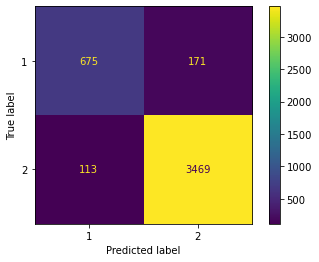

In [677]:
plot_confusion_matrix(svm, x_val, y_val)

#### Random forest

In [92]:
rfc = RandomForestClassifier()

In [93]:
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [94]:
rfc.score(x_val, y_val)

0.9625112917795845

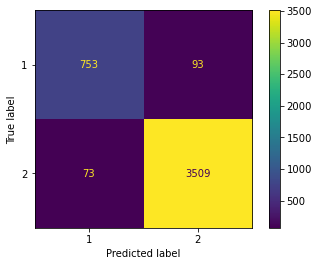

In [676]:
plot_confusion_matrix(rfc, x_val, y_val)

In [98]:
def plot_feature_importance(columns, feature_importance):
    plt.bar(columns, feature_importance)
    plt.xticks(rotation = 45)

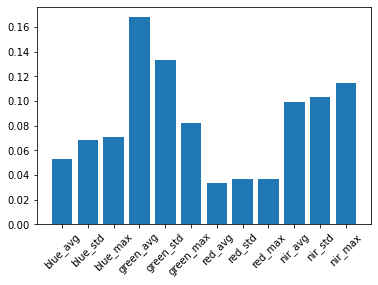

In [99]:
plot_feature_importance(df_train_val.columns[:-1], rfc.feature_importances_)

In [101]:
rfc.predict(x_val)

array([2, 2, 2, ..., 2, 1, 2], dtype=uint8)

In [104]:
pred = rfc.predict(df.iloc[:,:-1].values)

In [108]:
count_classes(pred)

Number of pixel taking 1 is 454496
Number of pixel taking 2 is 4004948


### Visualization

In [136]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches

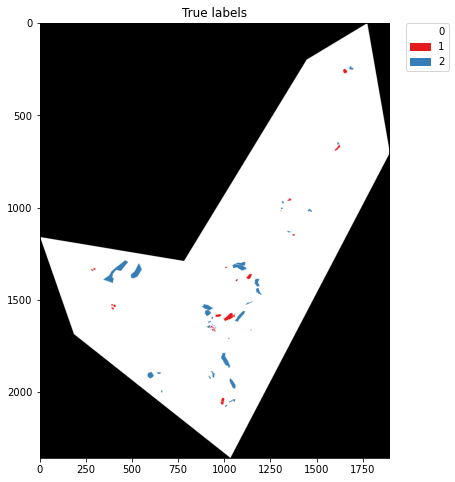

In [680]:
plot(mask_train, region_mask, 'True labels')

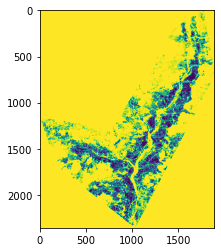

In [681]:
plt.imshow(pred.reshape(meta_train['height'], meta_train['width']))

In [241]:
pred

array([2, 2, 2, ..., 2, 2, 2], dtype=uint8)

In [243]:
pred_ = pred.copy()
pred_[df.label == 0] = 0

In [245]:
count_classes(pred_)

Number of pixel taking 0 is 4437305
Number of pixel taking 1 is 4371
Number of pixel taking 2 is 17768


In [249]:
label = df.label.to_numpy()

In [667]:
def get_mycmap(num_colors):
    cmap = 'Set1'
    if num_colors < len(mpl.cm.get_cmap(cmap).colors):
        colors_list = [np.array([1,1,1])]
        [colors_list.append(np.array(c)) for c in mpl.cm.get_cmap(cmap).colors[:num_colors]]
        mycmap = mpl.colors.ListedColormap(colors_list)
        mycmap.set_under(color='white')
        mycmap.set_bad(color='black')
        return mycmap
    else:
        return 'Set too many colors'

    
def map_values_to_colors(values, mycmap):
    # map values 
    norm = mpl.colors.Normalize(vmin=0, vmax=2, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=mycmap)
    mapped = mapper.to_rgba(values)
    
    # get the mapping of values to colors 
    maps = {}
    for v in range(int(mapper.get_clim()[0]), int(mapper.get_clim()[1])+1):
        maps[v] = mapper.get_cmap().colors[v]
        
    return mapped, maps


# def plot(classes_array, title):
#     fig = plt.subplots(figsize=(10,8))
#     im = plt.imshow(classes_array, vmin=0.01, vmax=len(mycmap.colors)+1,
#                     cmap=mycmap, interpolation=None)
#     values = np.unique(classes_array)
#     print(values)
#     # get the colors of the values, according to the 
#     # colormap used by imshow
#     colors = [im.cmap(im.norm(value)) for value in values]
#     # create a patch (proxy artist) for every color 
#     patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
#     # put those patched as legend-handles into the legend
#     plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
#     plt.title(title)


def plot(classes_array, region_mask, title):
    # get my color map
    mycmap = get_mycmap(2)

    # get the mapped colors
    mapped_colors, v2c = map_values_to_colors(classes_array, mycmap)
    mapped_colors[region_mask == 0] = np.array([0,0,0,1])
    
    # show images 
    fig = plt.subplots(figsize=(10,8))
    im = plt.imshow(mapped_colors, cmap=mycmap, interpolation=None)
    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=v2c[v], label=f"{v}") for v in v2c]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.title(title)

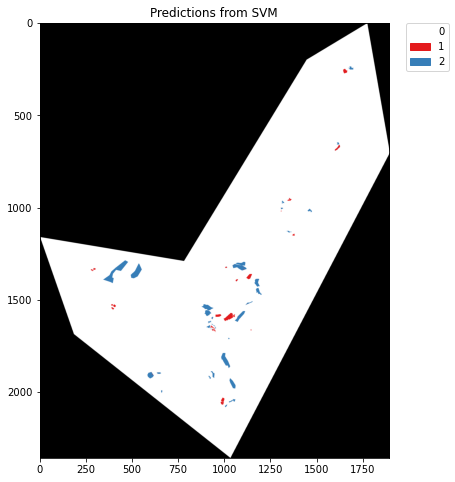

In [671]:
plot(pred_.reshape(meta_train['height'], meta_train['width']), region_mask, 'Predictions from SVM')

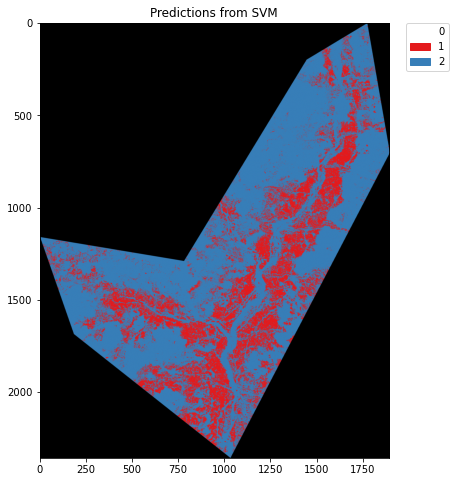

In [672]:
plot(pred.reshape(meta_train['height'], meta_train['width']), region_mask, 'Predictions from SVM')

#### show true color images

In [682]:
img_eg_path = img_dir + 'clip/L2A_T43SFR_A026271_20200703T053446.tiff'
img_eg = load_geotiff(img_eg_path)

In [ ]:
img

#### Kmeans

In [ ]:
def cluster(x, k=3):
    # x
    patch_x = x.reshape(-1, x.shape[-1])
    # fit 
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(patch_x)
    # y
    patch_y_pred = kmeans.labels_
    patch_y_pred = patch_y_pred.reshape(x.shape[0], x.shape[1])
    # draw image 
    out = label2rgb(patch_y_pred)
    print(f"x.shape {patch_x.shape}, y_pred.shape {patch_y_pred.shape}, num_cluster {k}")
    return out

In [84]:
out = cluster(df.to_numpy().reshape['height'], meta['width'], 3)

NameError: name 'meta' is not defined

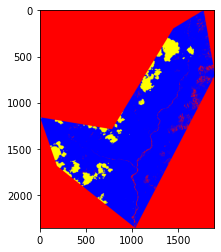

In [175]:
plt.imshow(out)